In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

import random as rand

import re
from matplotlib import colors

# to show all columns
pd.set_option('display.max_columns', 40)

In [2]:
df = pd.read_csv("carmax_data.csv")

print("The number of rows in the data is {}, and the number of columns in the data is {} ".
     format(df.shape[0], df.shape[1]))

# make dtypes of some variables 'category'

categoric_columns = ['make', 'model', 'trim_descrip', 'body', 'color', 
                     'make_appraisal', 'model_appraisal', 'trim_descrip_appraisal', 
                     'body_appraisal', 'color_appraisal']

for column in categoric_columns:
    df[column] = df[column].astype('category')
    
def convert_5k_increments(initial_str):
    m = re.findall(r'\d+', initial_str)
    return (int(m[0]) + 5) * 1000 if len(m) == 1 else (int(m[0]) + int(m[1])) / 2 * 1000
    
def convert_10k_increments(initial_str):
    m = re.findall(r'\d+', initial_str)
    return (int(m[0]) + 10) * 1000 if len(m) == 1 else (int(m[0]) + int(m[1])) / 2 * 1000

df['price'] = df['price'].apply(convert_5k_increments)
df['mileage'] = df['mileage'].apply(convert_5k_increments)
df['engine'] = df['engine'].str.extract('([\d].[\d]+)').astype("float")

df['appraisal_offer'] = df['appraisal_offer'].apply(convert_5k_increments)
df['mileage_appraisal'] = df['mileage_appraisal'].apply(convert_10k_increments)
df['engine_appraisal'] = df['engine_appraisal'].str.extract('([\d].[\d]+)').astype("float")

df['offer_40kplus'] = (df['appraisal_offer'] > 40000).astype(int)

df = df.drop(columns = ['model', 'model_appraisal', 'color', 'color_appraisal'])

# fill null values with median (numeric) and frequent values (categoric)
numeric_data = [c for c in df.select_dtypes(['int', 'float'])]
categoric_data = [c for c in df.select_dtypes(exclude = ['int', 'float'])]

for col in numeric_data:
    df[col].fillna(df[col].median(), inplace = True)
    
for col in categoric_data:
    df[col].fillna(df[col].value_counts().index[0], inplace = True)
    
appraisal_columns = ['price', 'appraisal_offer', 'online_appraisal_flag', 'model_year_appraisal', 
                     'mileage_appraisal', 'make_appraisal','trim_descrip_appraisal', 'body_appraisal',
                     'engine_appraisal', 'cylinders_appraisal', 'mpg_city_appraisal','mpg_highway_appraisal', 
                     'horsepower_appraisal','fuel_capacity_appraisal', 'market', 'offer_40kplus']

appraisal = df[appraisal_columns]

The number of rows in the data is 200000, and the number of columns in the data is 30 


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [4]:
y = appraisal['price']
x = appraisal.drop('price', axis = 1)
x = pd.get_dummies(x, drop_first = True)

In [5]:
rob_scaler = RobustScaler()
rob_scaler.fit(x)
x = rob_scaler.transform(x)

In [5]:
y = np.log(y)

# Linear Models

In [7]:
from sklearn.linear_model import LinearRegression
scores = []
linear_model = LinearRegression()
cv = KFold(n_splits = 5, random_state = 0, shuffle = True)
for train_idx, test_idx in cv.split(x):
    X_train, X_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
    linear_model.fit(X_train, y_train)
    linear_pred = linear_model.predict(X_test)
    linear_RMSE = np.sqrt(mean_squared_error(linear_pred, y_test))
    scores.append(linear_RMSE)
linear_score = np.mean(scores)

In [8]:
linear_score

0.355980689894602

In [14]:
from sklearn.linear_model import Lasso
lasso_scores = np.zeros(50)
lasso_train_errors = np.zeros(50)
lamda = list(np.linspace(1e-10, 1e-2, 50))
for i in range(50):
    scores = []
    train_scores = []
    lasso_model = Lasso(alpha = lamda[i])
    cv = KFold(n_splits = 5, random_state = 0, shuffle = True)
    for train_idx, test_idx in cv.split(x):
        X_train, X_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
        lasso_model.fit(X_train, y_train)
        lasso_pred = lasso_model.predict(X_test)
        lasso_RMSE = np.sqrt(mean_squared_error(lasso_pred, y_test))
        scores.append(lasso_RMSE)
        
        lasso_pred_train = lasso_model.predict(X_train)
        lasso_RMSE_train = np.sqrt(mean_squared_error(lasso_pred_train, y_train))
        train_scores.append(lasso_RMSE_train)
        
    lasso_score = np.mean(scores)
    lasso_scores[i] = lasso_score
    
    lasso_train_score = np.mean(train_scores)
    lasso_train_errors[i] = lasso_train_score

Text(0, 0.5, 'RMSE')

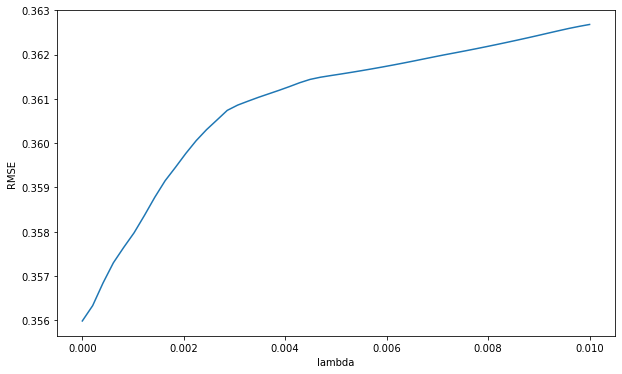

In [15]:
plt.plot(lamda, lasso_scores)
plt.xlabel("lambda")
plt.ylabel("RMSE")

In [16]:
lasso_scores[0]

0.35598068985245945

In [17]:
lasso_train_errors[0]

0.3558546106938476

In [18]:
from sklearn.linear_model import Ridge

ridge_scores = np.zeros(100)
ridge_train_scores = np.zeros(100)
lamda = list(np.linspace(0.001,20,100))
for i in range(len(ridge_scores)):
    scores = []
    train_scores = []
    ridge_model = Ridge(alpha = lamda[i])
    cv = KFold(n_splits = 5, random_state = 0, shuffle=True)
    for train_index, test_index in cv.split(x):
        X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
        ridge_model.fit(X_train, y_train)
        ridge_pred = ridge_model.predict(X_test)
        ridge_RMSE = np.sqrt(mean_squared_error(ridge_pred,y_test))
        scores.append(ridge_RMSE)
        
        ridge_pred_train = ridge_model.predict(X_train)
        ridge_RMSE_train = np.sqrt(mean_squared_error(ridge_pred_train,y_train))
        train_scores.append(ridge_RMSE_train)
        
    ridge_score = np.mean(scores)
    ridge_scores[i] = ridge_score
    
    ridge_train_score = np.mean(train_scores)
    ridge_train_scores[i] = ridge_train_score

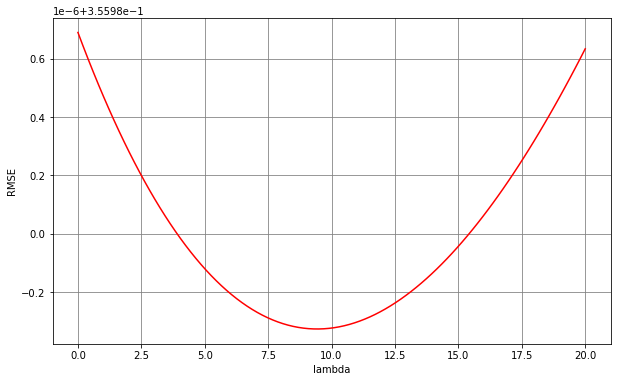

In [19]:
plt.plot(lamda, ridge_scores, color = 'red')
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.grid(color = 'grey')

In [21]:
np.min(ridge_scores)

0.3559796736089588

In [24]:
ridge_scores[47]

0.3559796736089588

In [25]:
ridge_train_scores[47]

0.35585557996584627

In [22]:
np.argmin(ridge_scores)

47

In [23]:
np.linspace(0.001,20,100)[47]

9.495474747474747

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [8]:
from sklearn.ensemble import RandomForestRegressor

rr_scores = np.zeros(9)
rr_train_scores = np.zeros(9)
N = [10, 20, 50, 100, 150, 200, 300, 400, 500]
for i in range(len(rr_scores)):
    scores = []
    train_scores = []
    rr = RandomForestRegressor(n_estimators = N[i])
    cv = KFold(n_splits = 5, random_state = 0, shuffle=True)
    X_train, X_test, y_train, y_test = train_test_split(x, y)
    rr.fit(X_train, y_train)
    rr_pred = rr.predict(X_test)
    rr_RMSE = np.sqrt(mean_squared_error(rr_pred,y_test))
        
    rr_pred_train = rr.predict(X_train)
    rr_RMSE_train = np.sqrt(mean_squared_error(rr_pred_train,y_train))

        
    rr_scores[i] = rr_RMSE
    
    rr_train_scores[i] = rr_RMSE_train
    
    print("done ", N[i])

done  10
done  20
done  50
done  100
done  150
done  200
done  300
done  400
done  500


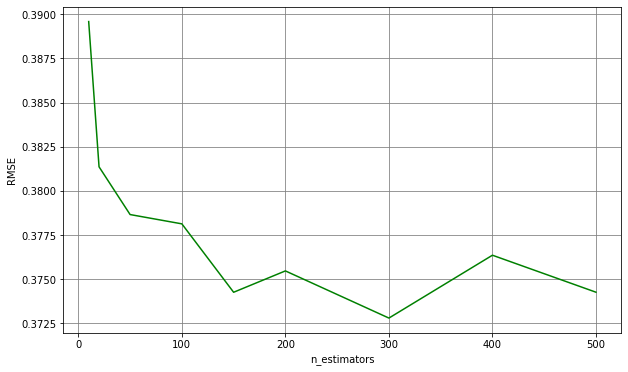

In [9]:
plt.plot(N, rr_scores, color = 'green')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.grid(color = 'grey')

In [10]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [11]:
rr_final = RandomForestRegressor(n_estimators = 300)
#Training the Random Forest Regressor
print("Random Forest Regressor Scores")
scores = cross_val_score(rr_final, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
random_forest_scores = np.sqrt(-scores)
display_scores(random_forest_scores)
print("\n")

Random Forest Regressor Scores
Scores:  [0.37684696 0.37452247 0.3724563  0.37503902 0.37474849]
Mean:  0.3747226496853347
Standard Deviation:  0.0013992743713812615




In [15]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_scores = np.zeros(10)
lamda = list(np.linspace(0.01,0.1,10))
for i in range(len(gbr_scores)):
    scores = []
    gbr = GradientBoostingRegressor(learning_rate = lamda[i])
    X_train, X_test, y_train, y_test = train_test_split(x, y)
    gbr.fit(X_train, y_train)
    gbr_pred = gbr.predict(X_test)
    gbr_RMSE = np.sqrt(mean_squared_error(gbr_pred,y_test))
        
    gbr_scores[i] = gbr_RMSE
    
    print("done ", lamda[i])

done  0.01
done  0.020000000000000004
done  0.030000000000000006
done  0.04000000000000001
done  0.05000000000000001
done  0.06000000000000001
done  0.07
done  0.08
done  0.09000000000000001
done  0.1


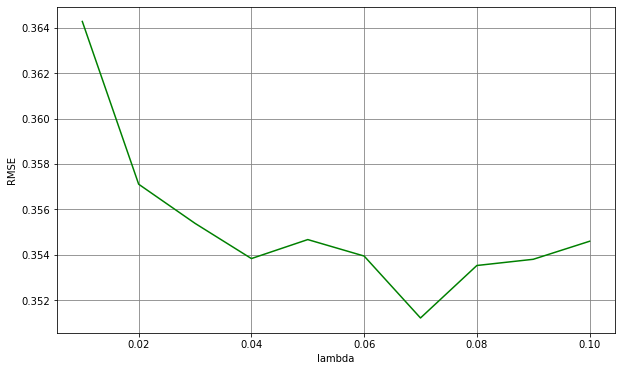

In [16]:
plt.plot(lamda, gbr_scores, color = 'green')
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.grid(color = 'grey')

In [6]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(x, y)

#Create function to displaying scores
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())
    
gbr = GradientBoostingRegressor(learning_rate = 0.07)

#Training the Gradient Boosting Regressor
print('Gradient Boosting Regressor Scores')
scores = cross_val_score(gbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
gradient_boosting_regressor = np.sqrt(-scores)
display_scores(gradient_boosting_regressor)
print("\n")


Gradient Boosting Regressor Scores
Scores:  [0.3544877  0.3512792  0.35417519 0.35127824 0.35692407]
Mean:  0.3536288812262788
Standard Deviation:  0.002141997554572081




In [17]:
np.min(gbr_scores)

0.35121086797444745

In [19]:
lamda[np.argmin(gbr_scores)]

0.07

In [26]:
import xgboost

xgb_scores = np.zeros(10)
lamda = list(np.linspace(0.01,0.1,10))

for i in range(len(xgb_scores)):
    scores = []
    xgb = xgboost.XGBRegressor()
    X_train, X_test, y_train, y_test = train_test_split(x, y)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_RMSE = np.sqrt(mean_squared_error(xgb_pred,y_test))
        
    xgb_scores[i] = xgb_RMSE
    
    print("done ", lamda[i])

done  0.01
done  0.020000000000000004
done  0.030000000000000006
done  0.04000000000000001
done  0.05000000000000001
done  0.06000000000000001
done  0.07
done  0.08
done  0.09000000000000001
done  0.1


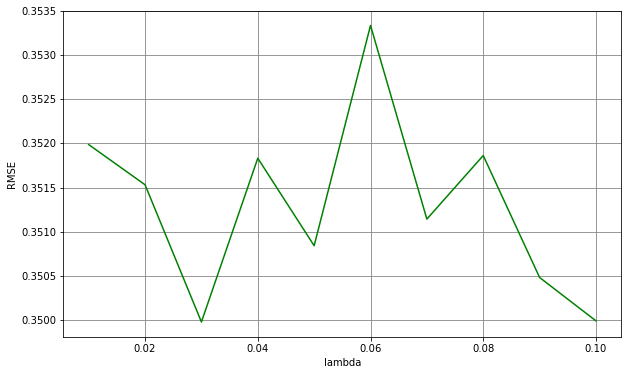

In [27]:
plt.plot(lamda, xgb_scores, color = 'green')
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.grid(color = 'grey')

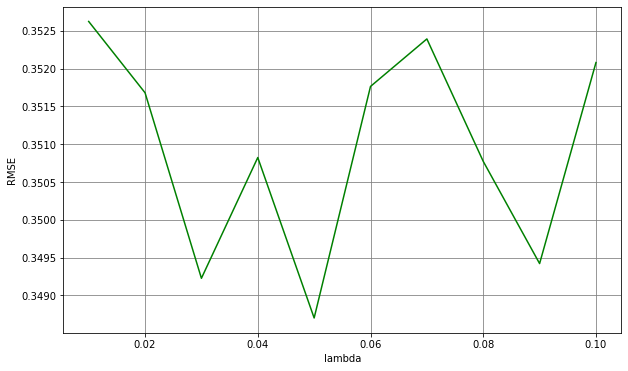

In [23]:
plt.plot(lamda, xgb_scores, color = 'green')
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.grid(color = 'grey')

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
rr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgb = xgb.XGBRegressor()

#Create function to displaying scores
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())
    
#Training the Random Forest Regressor
print("Random Forest Regressor Scores")
scores = cross_val_score(rr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
random_forest_scores = np.sqrt(-scores)
display_scores(random_forest_scores)
print("\n")

#Training the Gradient Boosting Regressor
print('Gradient Boosting Regressor Scores')
scores = cross_val_score(gbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
gradient_boosting_regressor = np.sqrt(-scores)
display_scores(gradient_boosting_regressor)
print("\n")

#Training the Linear Regression
print('Linear Regression Scores')
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
linear_regression = np.sqrt(-scores)
display_scores(linear_regression)
print("\n")

#Training the Extreme Gradient Boosting
print("xGB Scores")
scores = cross_val_score(xgb, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
xgb_regressor = np.sqrt(-scores)
display_scores(xgb_regressor)

Random Forest Regressor Scores
Scores:  [0.37484806 0.37793917 0.37615326 0.37385396 0.37146645]
Mean:  0.3748521817927354
Standard Deviation:  0.0021763247379533385


Gradient Boosting Regressor Scores
Scores:  [0.3529241  0.35670062 0.35435441 0.35194911 0.35007312]
Mean:  0.35320027348948074
Standard Deviation:  0.0022363003452952925


Linear Regression Scores
Scores:  [0.35588714 0.35996944 0.3578873  0.35484851 0.3530104 ]
Mean:  0.35632055861943013
Standard Deviation:  0.002411676042371416


xGB Scores
Scores:  [0.35172773 0.35657399 0.35270606 0.35086259 0.34860821]
Mean:  0.3520957149907879
Standard Deviation:  0.0026171021652924694


Permutation Importances